In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoModel , AutoImageProcessor , AutoTokenizer 
from datasets import load_dataset , Dataset
from datasets import Image as dImage
from PIL import Image
import torch
from torch import nn

torch.cuda.empty_cache()

# import os
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

2024-05-16 12:05:38.278037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 12:05:38.840690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_acc = pd.read_pickle("./vqa_v2_acc.pkl")
df_acc.head()

question      question_type  \
0    What is this photo taken looking through?       what is this   
1           What position is this man playing?               what   
2             What color is the players shirt?  what color is the   
3  Is this man a professional baseball player?            is this   
4                      What color is the snow?  what color is the   

   question_id                         image_id answer_type  \
0    458752000  COCO_train2014_000000458752.jpg       other   
1    458752001  COCO_train2014_000000458752.jpg       other   
2    458752002  COCO_train2014_000000458752.jpg       other   
3    458752003  COCO_train2014_000000458752.jpg      yes/no   
4    262146000  COCO_train2014_000000262146.jpg       other   

                                               label  
0  {'ids': ['net', 'netting', 'mesh'], 'weights':...  
1  {'ids': ['pitcher', 'catcher'], 'weights': [0....  
2              {'ids': ['orange'], 'weights': [1.0]}  
3    {'ids': ['yes', 'no'], 'weights': [0.94, 0.06]}  
4               {'ids': ['white'], 'weights': [1.0]}

In [3]:
np.array(Image.open("./train2014_3d/" + df_acc["image_id"][0])).shape

(480, 640, 3)

In [4]:
# SAMPLES = 100
# df = df_acc[:SAMPLES]

df = df_acc.groupby('question_type').sample(n=500 , replace=True)
df = df.reset_index(drop=True)
SAMPLES = len(df)

print("Number of samples are : " , SAMPLES)

df.head()

Number of samples are :  32500


question question_type  \
0  Are people standing on the sidewalk or in the ...           are   
1                Are any people seated on the couch?           are   
2      Are any of the animals looking at each other?           are   
3    Are all of the sheep facing the same direction?           are   
4                    Are horns allowed to be honked?           are   

   question_id                         image_id answer_type  \
0    127100017  COCO_train2014_000000127100.jpg       other   
1    363468007  COCO_train2014_000000363468.jpg      yes/no   
2    184223002  COCO_train2014_000000184223.jpg      yes/no   
3    504259008  COCO_train2014_000000504259.jpg      yes/no   
4    523581002  COCO_train2014_000000523581.jpg      yes/no   

                                               label  
0  {'ids': ['in road', 'road', 'no'], 'weights': ...  
1                  {'ids': ['no'], 'weights': [1.0]}  
2    {'ids': ['yes', 'no'], 'weights': [0.56, 0.44]}  
3                 {'ids': ['yes'], 'weights': [1.0]}  
4                  {'ids': ['no'], 'weights': [1.0]}

Creating Labels

In [5]:
import itertools

labels = [item['ids'] for item in df['label'].to_list()]
flattened_labels = list(itertools.chain(*labels))
unique_labels = list(set(flattened_labels))

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()} 

In [33]:
label2id

{'john mcenroe': 0,
 'campground': 1,
 'unemployed': 2,
 '37': 3,
 'orange, black and yellow': 4,
 'seoul on wheels': 5,
 'hobby': 6,
 'they are playing wii': 7,
 'wateraid': 8,
 'rach <3 kevin': 9,
 'birthday party': 10,
 '240': 11,
 'perez': 12,
 'no hot dogs': 13,
 'work party': 14,
 'right there': 15,
 'sitting in open suitcase': 16,
 'delicious': 17,
 'to cut cake': 18,
 'none of them': 19,
 'cellular': 20,
 'swim shorts': 21,
 'fake top hat': 22,
 'jenic': 23,
 'glass containers': 24,
 'little black 1 and white 1': 25,
 'pictures of plants': 26,
 'she is using cell phone': 27,
 '0081': 28,
 'shubh': 29,
 'there are no clouds': 30,
 '12 ounces': 31,
 'it is far away': 32,
 'trolley goes down it': 33,
 'coffee cake': 34,
 'blet': 35,
 'listening to her phone': 36,
 'flat grassland': 37,
 'everyone is close to each other': 38,
 'wild horse': 39,
 'wiffle': 40,
 'diamond': 41,
 'ski suit': 42,
 'artech': 43,
 'crumbs from cake': 44,
 'choose wii': 45,
 'cardboard cup': 46,
 'eggs flo

In [34]:
NUM_CLASSES = len(id2label)
print("Number of Classes : " , NUM_CLASSES)

Number of Classes :  23808


Testing BERT and ViT

In [12]:
MAX_LEN = 40

In [13]:
DEVICE = "cuda"

vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
# model = AutoModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)
# vit_model = AutoModel.from_pretrained("google/vit-base-patch16-224")

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
from transformers import BertTokenizer , BertModel

bert_processor = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### TensorFlow

Create ViT and BERT models

In [15]:
from transformers import TFAutoModelForSequenceClassification , TFAutoModel , TFAutoModelForImageClassification , TFBertModel
from tensorflow.keras.optimizers import Adam

vit_tf_model = TFAutoModel.from_pretrained("google/vit-base-patch16-224")
bert_tf_model = TFBertModel.from_pretrained('bert-base-uncased')


2024-05-15 22:42:21.208243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 22:42:21.232060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 22:42:21.232198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [16]:
class Dataset_Generator(tf.keras.utils.Sequence) :
    def __init__(self, image_filenames, questions , labels, batch_size) :
        self.image_filenames = image_filenames
        self.questions = questions
        self.labels = labels
        self.batch_size = batch_size


    def __len__(self) :
        return int(len(self.image_filenames) / self.batch_size)


    def __getitem__(self, idx) :
        batch_x_img = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_x_text = self.questions[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        batch_x_img = [Image.open(f"train2014_3d/{i}") for i in batch_x_img]
        
        img_feat = vit_processor(batch_x_img , return_tensors = "np")
        text_feat = bert_processor(batch_x_text , padding='max_length', max_length=MAX_LEN, truncation=True, return_tensors="np")
        
        labels = []
        for i in batch_y:
            r = [0 for i in id2label]
            for t , w in zip(i["ids"] , i["weights"]):
                r[label2id[t]] = w
            labels.append(r)
        
        # return x , y
        # return np.array([
        #         resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
        #             for file_name in batch_x])/255.0, np.array(batch_y)
        # print(labels)
        return [img_feat["pixel_values"] , text_feat["input_ids"] , text_feat["attention_mask"]] , np.array(labels)

In [35]:
BATCH_SIZE = 16

validation_split = 0.2
validation_split_ind = - int(validation_split * SAMPLES)

df_train = df.sample(frac=1).reset_index(drop=True) #shuffle the dataset

df_train = df_train[: validation_split_ind]
df_test = df_train[validation_split_ind : ]

training_gen = Dataset_Generator(
    df_train["image_id"].to_list(), 
    df_train["question"].to_list(), 
    df_train["label"].to_list(),
    BATCH_SIZE
)

validation_gen = Dataset_Generator(
    df_test["image_id"].to_list(), 
    df_test["question"].to_list(), 
    df_test["label"].to_list(),
    BATCH_SIZE
)

len(df_train) , len(df_test)

(26000, 6500)

Build our Custom Model

In [36]:
def build_model():
    vit_inputs = tf.keras.layers.Input(shape=(3, 224, 224))
    x_vit = vit_tf_model(vit_inputs).pooler_output
    
    bert_input1 = tf.keras.layers.Input(shape=(MAX_LEN,) , dtype=tf.int32)
    bert_input2 = tf.keras.layers.Input(shape=(MAX_LEN,) , dtype=tf.int32)
    x_bert = bert_tf_model(input_ids=bert_input1 , attention_mask=bert_input2).pooler_output
    
    # x = np.concatenate([x_vit , x_bert])
    out = tf.keras.layers.Concatenate(axis=1)([x_vit, x_bert])
    # x = x_bert
    
    out = tf.keras.layers.Dense(256 , input_shape=(768*2,) , activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    # out = tf.keras.layers.Dense(512 , input_shape=(768*2,) , activation='relu')(out)
    # out = tf.keras.layers.Dropout(0.25)(out)
    # out = tf.keras.layers.Dense(256 , activation='relu')(out)
    # out = tf.keras.layers.Dropout(0.25)(out)
    out = tf.keras.layers.Dense(64 , activation='relu')(out)
    out = tf.keras.layers.BatchNormalization()(out)
    out = tf.keras.layers.Dense(NUM_CLASSES , activation='softmax')(out)
    
    model = tf.keras.models.Model(inputs=[vit_inputs , bert_input1 , bert_input2] , outputs=out)
    
    return model


modelx = build_model()
modelx.compile(optimizer=Adam(3e-5) , loss="categorical_crossentropy", metrics=['accuracy'])
modelx.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 3, 224, 224)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 tf_vi_t_model (TFViTModel)  TFBaseModelOutputWithPooli   8638924   ['input_4[0][0]']             
                             ng(last_hidden_state=(None   8                                 

In [37]:
modelx.fit_generator(generator=training_gen,
                    epochs = 20,
                    validation_data=validation_gen
                    )


Epoch 1/20


/tmp/ipykernel_930871/2267110838.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelx.fit_generator(generator=training_gen,


1625/1625 [==============================] - 606s 343ms/step - loss: 9.0301 - accuracy: 0.2219 - val_loss: 7.8102 - val_accuracy: 0.2192
Epoch 2/20
1625/1625 [==============================] - 568s 350ms/step - loss: 7.1433 - accuracy: 0.2316 - val_loss: 6.1323 - val_accuracy: 0.2352
Epoch 3/20
1625/1625 [==============================] - 569s 350ms/step - loss: 5.9864 - accuracy: 0.2375 - val_loss: 5.3949 - val_accuracy: 0.2609
Epoch 4/20
1625/1625 [==============================] - 569s 350ms/step - loss: 5.4272 - accuracy: 0.2428 - val_loss: 5.0465 - val_accuracy: 0.2717
Epoch 5/20
1625/1625 [==============================] - 569s 350ms/step - loss: 5.1483 - accuracy: 0.2745 - val_loss: 4.8918 - val_accuracy: 0.3143
Epoch 6/20
1625/1625 [==============================] - 569s 350ms/step - loss: 4.9471 - accuracy: 0.3101 - val_loss: 4.6561 - val_accuracy: 0.3738
Epoch 7/20
1625/1625 [==============================] - 569s 350ms/step - loss: 4.7557 - accuracy: 0.3692 - val_loss: 4.460

In [39]:
modelx.save("vqa_20k.keras")

In [45]:
modelx2 = tf.keras.models.clone_model(modelx)
modelx2.set_weights(modelx.get_weights())
modelx2.compile(optimizer=Adam(3e-5) , loss="categorical_crossentropy", metrics=['accuracy'])

In [46]:
modelx2.fit_generator(generator=training_gen,
                    epochs = 20,
                    validation_data=validation_gen
                    )

Epoch 1/20


/tmp/ipykernel_930871/3734039461.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelx2.fit_generator(generator=training_gen,
2024-05-16 12:02:14.692360: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.23MiB (rounded to 9682944)requested by op model_1/tf_vi_t_model_3/vit/encoder/layer_._9/attention/attention/key/Tensordot/MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-05-16 12:02:14.692502: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-05-16 12:02:14.692517: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 400, Chunks in use: 399. 100.0KiB allocated for chunks. 99.8KiB in use in bin. 11.7Ki

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/tf_vi_t_model_3/vit/encoder/layer_._9/attention/attention/key/Tensordot/MatMul' defined at (most recent call last):
    File "/home/user/miniconda3/envs/python38/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/user/miniconda3/envs/python38/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/home/user/miniconda3/envs/python38/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/user/miniconda3/envs/python38/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/user/miniconda3/envs/python38/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_930871/3734039461.py", line 1, in <module>
      modelx2.fit_generator(generator=training_gen,
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 2810, in fit_generator
      return self.fit(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 764, in run_call_with_unpacked_inputs
      ignore_mismatched_sizes=ignore_mismatched_sizes,
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/models/vit/modeling_tf_vit.py", line 766, in call
      outputs = self.vit(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 764, in run_call_with_unpacked_inputs
      ignore_mismatched_sizes=ignore_mismatched_sizes,
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/models/vit/modeling_tf_vit.py", line 612, in call
      encoder_outputs = self.encoder(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/models/vit/modeling_tf_vit.py", line 522, in call
      for i, layer_module in enumerate(self.layer):
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/models/vit/modeling_tf_vit.py", line 526, in call
      layer_outputs = layer_module(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/models/vit/modeling_tf_vit.py", line 458, in call
      attention_outputs = self.attention(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/models/vit/modeling_tf_vit.py", line 360, in call
      self_outputs = self.self_attention(
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/transformers/models/vit/modeling_tf_vit.py", line 266, in call
      mixed_key_layer = self.key(inputs=hidden_states)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/user/miniconda3/envs/python38/lib/python3.8/site-packages/keras/src/layers/core/dense.py", line 244, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'model_1/tf_vi_t_model_3/vit/encoder/layer_._9/attention/attention/key/Tensordot/MatMul'
OOM when allocating tensor with shape[3152,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/tf_vi_t_model_3/vit/encoder/layer_._9/attention/attention/key/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_422022]

Inference

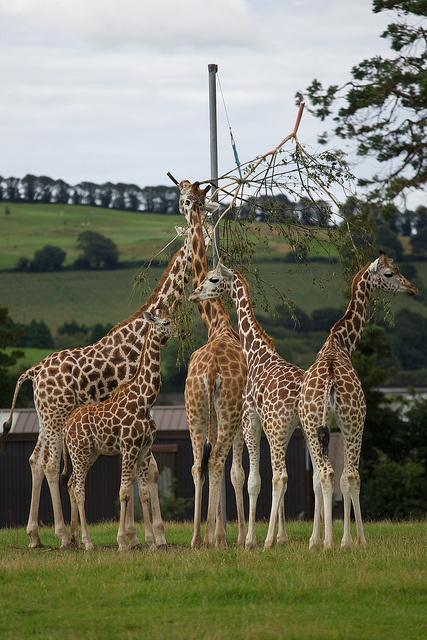

Question :  gow many animals are there
1/1 [==============================] - 0s 38ms/step
Answer :  no


In [50]:
test = df.iloc[0]
# test_question = test["question"]
test_question = "gow many animals are there"
test_image = Image.open("train2014_3d/" + test["image_id"])

display(test_image)

test_text_feat = bert_processor([test_question] , padding='max_length', max_length=MAX_LEN, truncation=True, return_tensors="np")
test_image_feat = vit_processor([test_image] , return_tensors="np")["pixel_values"]


print("Question : " , test_question)
ans = modelx.predict([test_image_feat , test_text_feat["input_ids"] , test_text_feat["attention_mask"]])
ans = np.argmax(ans)
ans = id2label[ans]
print("Answer : " , ans)
